# DARPA-ARC Notebook 3: fMRI First Levels

## Generate Subject Task Regressors

In [5]:
from my_settings import (os, op, np, read_csv, version, root_dir, mri_dir, 
                         task, subjects, stan_models, models, plt,
                         n_acq, tr, sfreq, modality,
                         choice_time, session, conditions_dict)
from scipy.special import gammaln
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define useful functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#
def spm_hrf(RT, P=None, fMRI_T=16):
    p = np.array([6, 16, 1, 1, 6, 0, 32], dtype=float)
    if P is not None:
        p[0:len(P)] = P
    #
    _spm_Gpdf = lambda x, h, l: np.exp(h * np.log(l) + (h - 1) * np.log(x) - (l * x) - gammaln(h))
    # modelled hemodynamic response function - {mixture of Gammas}
    dt = RT / float(fMRI_T)
    u = np.arange(0, int(p[6] / dt + 1)) - p[5] / dt
    with np.errstate(divide='ignore'):  # Known division-by-zero
        hrf = _spm_Gpdf(u, p[0] / p[2], dt / p[2]) - _spm_Gpdf(u, p[1] / p[3],
                                                               dt / p[3]) / p[4]
    idx = np.arange(0, int((p[6] / RT) + 1)) * fMRI_T
    hrf = hrf[idx]
    hrf = hrf / np.sum(hrf)
    return hrf

for model_name, analysis, epochs_type in models:
    #
    print(model_name, analysis, epochs_type)
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Main loop.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
    #
    csv = op.join(root_dir, 'stan_results/%s_%s_%s.csv' % (task, modality, version))
    df = read_csv(csv)
    for subject in subjects:
        #
        print(subject)
        #
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Initialize regressors.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
        #
        ## Setup timing information.
        total_time = n_acq * tr
        times = np.arange(0, total_time+1./sfreq, 1./sfreq)
        n_times = times.shape[0]
        #
        ## Extract information.
        subject_data = df.loc[df.Subject==subject, ['RiskOnset', 'ResponseTime']].copy().values
        trial_onset, rt = subject_data.T.round(int(np.log10(sfreq)))
        rt += 0.5                     # Reaction time does not factor 0.5s of risk presentation.
        rt = np.where(np.isnan(rt), choice_time, rt)
        if model_name != 'parameter':
            results_file = op.join(root_dir, 'stan_results/%s_%s_%s_regressors.csv' % (task, model_name, version))
            model_df = read_csv(results_file)
        else:
            model_df = df
        if analysis == 'All' or analysis == 'PCA':
            subject_data = model_df.loc[model_df.Subject==subject, ['ddb', 'RiskType', 'Reward']].copy().values
            DDB, risk, reward = subject_data.T.round(int(np.log10(sfreq)))
            DDB = np.where(np.isnan(DDB), 0, DDB)
            risk = np.where(risk < 2, 0.1, np.where(risk < 3, 0.5, 0.9))
            analysis_data = np.array([DDB, risk, reward]).T
        elif analysis == 'DelibMod':
            subject_data = model_df.loc[model_df.Subject==subject, 'ddb'].copy().values
            DDB = subject_data.T.round(int(np.log10(sfreq)))
            DDB = np.where(np.isnan(DDB), 0, DDB)
            analysis_data = np.array([DDB]).T
        elif analysis == 'Risk':
            subject_data = model_df.loc[model_df.Subject==subject, 'RiskType'].copy().values
            risk = subject_data.T.round(int(np.log10(sfreq)))
            risk = np.where(risk < 2, 0.1, np.where(risk < 3, 0.5, 0.9))
            analysis_data = np.array([risk]).T
        elif analysis == 'Reward':
            subject_data = model_df.loc[model_df.Subject==subject, 'Reward'].copy().values
            reward = subject_data.T.round(int(np.log10(sfreq)))
            analysis_data = np.array([reward]).T
        else:
            raise ValueError('Analysis %s not recognized, handing of this analysis ' % analysis +
                             'using the behavioral data must be programmed')
        #
        ## Initialize boxcars.
        conditions = ['Control'] + conditions_dict[analysis]
        neural_signal = np.zeros((len(conditions), n_times))
        #
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Generate decision-making boxcars.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
        #
        for onset, duration, parmod in zip(trial_onset, rt, analysis_data):
            if epochs_type == 'VariableEpochs':
                mask = (times >= onset) & (times <= onset + duration)
            elif epochs_type == 'FixedEpochs':
                mask = (times >= onset) & (times <= onset + choice_time)
            else:
                raise ValueError('Unrecognized epochs_type %s' % epochs_type)
            #
            neural_signal[0, mask] += 1                   # Deliberation (intercept)
            for i, p in enumerate(parmod):
                neural_signal[i + 1, mask] += p           # Deliberation (condition)

        #
        ## Perform convolution.
        hrf = spm_hrf(1./sfreq)
        bold_signal = np.apply_along_axis(np.convolve, 1, neural_signal, v=hrf)
        bold_signal = bold_signal[:,:neural_signal.shape[-1]] # Set back to original length.
        #
        ## Downsample to start of TR.
        tr_onsets = np.insert( np.cumsum( np.ones(n_acq-1)*tr ), 0, 0 )
        #
        ds = np.in1d(times, tr_onsets)
        if not ds.sum() == n_acq: 
            raise ValueError('Oh noes!')
        #
        bold_signal = bold_signal[:,ds]
        #
        ## Normalize regressors (max height=1).
        bold_signal = (bold_signal.T / bold_signal.max(axis=1)).T
        #
        if analysis == 'PCA':
            risk, reward = bold_signal[2], bold_signal[3]
            X2 = np.column_stack([risk, reward])
            pca = PCA(n_components=2)
            X2 = pca.fit_transform(X2)
            bold_signal[2] = X2[:, 0]
            bold_signal[3] = X2[:, 1]
        ## Save task regressors.
        for i, condition in enumerate(conditions):
            f = '%s/fmri_first_levels/%s/%s_%03d/%03d/%s.%s.%s.%s.%s.par' % (root_dir, subject, task, session, session, 
                                                                             version, model_name, analysis, epochs_type,
                                                                             condition)
            try: np.savetxt(f, bold_signal[i][:,np.newaxis], fmt='%s')
            except IOError as e: print(e)
        #
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Compute and plot VIF.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
        #
        ## Compute VIF.
        bold_signal = bold_signal.T
        vif = np.array([variance_inflation_factor(bold_signal,i) for i in range(len(conditions))])
        if np.any(np.isinf(vif)): raise ValueError('Oh noes! Check VIF!')
        #
        ## Open figure.
        fig = plt.figure(figsize=(18,6))
        colors = ['#377eb8','#4daf4a','#e41a1c','#984ea3','#ff7f00','#386cb0','#e7298a','#66a61e']
        #
        ## Plot VIF.
        ax = plt.subplot2grid((1,3),(0,0),rowspan=2)
        ax.bar(np.arange(len(conditions)), vif, 0.9, color='#7ec0ee')
        ax.set_xlim(-0.6)
        ax.set_xticks(np.arange(len(conditions)))
        ax.set_xticklabels(conditions)
        ax.set_ylim(0, 25)
        ax.set_ylabel('VIF', fontsize=20)
        ax.set_title('%s Collinearity' % subject.upper(), fontsize=24)
        #
        ## Plot decision-making regressors.
        ax = plt.subplot2grid((1,3),(0,1),colspan=2)
        for arr, label, color in zip(bold_signal.T, conditions, colors):
            ax.plot(tr_onsets, arr, linewidth=2, color=color, alpha=0.8, label=label)
        ax.legend(loc=2, bbox_to_anchor=(1.0,0.7), frameon=False, borderpad=0, handletextpad=0.1)
        ax.set_xticks([])
        ax.set_xlim(0,180)
        ax.set_yticks([])
        ax.set_title('Decision Making', fontsize=24)
        #
        plt.subplots_adjust(left=0.05, wspace=0.05, hspace=0.3)
        if not op.isdir(op.join(root_dir, 'plots', version, 'vif')): os.makedirs(op.join(root_dir, 'plots', version, 'vif'))
        plt.savefig(op.join(root_dir, 'plots/%s/vif/%s_reg2_%s_%s_%s.png' % (version, subject, model_name, analysis, epochs_type)))
        plt.close('all')

print('Done.')

hierarchical PCA VariableEpochs
hc001
hc002
hc004
hc005
hc006
hc007
hc008
hc009
hc010
hc011
hc013
hc015
hc017
hc019
hc021
hc022
hc023
hc025
hc026
hc027
hc028
hc029
hc030
hc031
hc032
hc033
hc034
hc036
Done.


## Generate Subject Timepoint Censors

In [12]:
from my_settings import (os, op, np, read_csv, version, root_dir, mri_dir,
                         task, subjects, plt, thresholds, session, task)
from scipy.signal import detrend
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define TR onsets.
tr_onsets = np.insert( np.cumsum( np.ones(n_acq - 1) * tr ), 0, 0 )

## Get subjects list.

info = open(op.join(root_dir, 'fmri_second_levels/nuisance_info.csv'),'w')
info.write('Subject,n_mc,FD=' + ',FD='.join([str(fd) for fd in thresholds]) + '\n')

for subject in subjects:
    #
    print(subject)
    info.write('%s,' %subject)
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Compute framewise displacement.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    #
    ## Read motion data.
    mc = os.path.join(mri_dir, subject, 'arc_001', '001', 'fmcpr.mcdat')
    mc = np.loadtxt(mc)[:,1:7]
    #
    ## Invert angular displacement.
    fd = mc.copy()
    fd[:,:3] = np.deg2rad(fd[:,:3]) 
    fd[:,:3] *= 50
    #
    ## Compute framewise displacement (See Power 2012, 2014).
    fd = np.insert( np.abs( np.diff(fd, axis=0) ).sum(axis=1), 0, 0 )
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Compute motion regressors.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    #
    ## Remove trends.
    mc = detrend(mc, axis=0, type='constant')
    mc = detrend(mc, axis=0, type='linear')
    #
    ## Perform PCA.
    pca = PCA(n_components=6)
    mc = pca.fit_transform(mc)
    #
    ## Take only the number of components explaining 90% of the variance.
    varexp = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(varexp >= 0.9) + 1
    mc = mc[:,:n_components]
    #
    ## Save motion regressor.
    f = '%s/fmri_first_levels/%s/%s_%03d/%03d/%s.mc.par' % (root_dir, subject, task, session, session, version)
    np.savetxt(f, mc, fmt='%s')
    info.write('%s,' %n_components)
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Write scrubbers.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    #
    for threshold in thresholds:
        #
        ## Find threshold violations.
        if not threshold: ix, = np.where(fd >= np.inf)
        else: ix, = np.where(fd >= threshold)
        #       
        ## Save.
        info.write('%s,' %len(ix))
        f = '%s/fmri_first_levels/%s/%s_%03d/%03d/%s.censor.%s.par' % (root_dir, subject, task, session, session, version, threshold)
        if len(ix): np.savetxt(f, tr_onsets[ix,np.newaxis], fmt='%s')
        #
    info.write('\n')
    #
info.close()
print('Done.')

hc001
hc002
hc004
hc005
hc006
hc007
hc008
hc009
hc010
hc011
hc013
hc015
hc017
hc019
hc021
hc022
hc023
hc025
hc026
hc027
hc028
hc029
hc030
hc031
hc032
hc033
hc034
hc036
Done.


Now run fmri_first_levels/first_levels.csh -check_threshs

This runs first levels for just the first model over the given framewise displacements to check to see which to use for all of the models

## Censor Analysis: Precompute F maps

In [5]:
from my_settings import (os, op, np, read_csv, version, 
                         root_dir, mri_dir, concat_sess_dir,
                         task,  subjects, models, plt,
                         thresholds, nib, sm, spaces,
                         n_subj, X, n_pred, wls, fd, 
                         conditions_dict) 

model_name, analysis, epochs_type = models[0]
#
condition = conditions_dict[analysis][0]
#
for space in spaces:
    #
    for fd in thresholds:
        #
        print(model_name, analysis, epochs_type, condition, space, fd)
        #
        results_dir = op.join(concat_sess_dir, '%s.%s.%s.%s.%s.%s.%s.%s' % (version, task, model_name, analysis, 
                                                                            epochs_type, sm, fd, space))
        this_results_dir = op.join(results_dir, '%s.%s.%s.%s.%s.par' % (version, model_name, analysis, epochs_type, condition))
        #
        ## Load data
        ces = nib.load(op.join(this_results_dir, 'ces.nii.gz')).get_data().squeeze()
        cesvar = nib.load(op.join(this_results_dir, 'cesvar.nii.gz')).get_data().squeeze()
        affine = nib.load(op.join(this_results_dir, 'ces.nii.gz')).affine
        #
        ## Reshaping of MNI305 data.
        if space == 'mni305':
            x,y,z,n_subj = ces.shape
            ces = ces.reshape(x*y*z,n_subj)
            cesvar = cesvar.reshape(x*y*z,n_subj)
        #
        ## Preallocate arrays for results.
        cesvar = np.abs(1./cesvar)
        include, = np.where(~np.isinf(cesvar).sum(axis=1).astype(bool))
        Fmap = np.repeat(np.nan, ces.shape[0])
        #
        ## Perform WLS.
        for i in include:
            #
            ## Update variables
            Y = ces[i]
            W = np.diag(cesvar[i])
            _, Fmap[i] = wls(X,Y,W)
        #
        ## Reshape.
        if space == 'mni305': Fmap = Fmap.reshape(x,y,z)
        #
        ## Save.
        for _ in range(4 - len(Fmap.shape)): Fmap = np.expand_dims(Fmap, -1)
        obj = nib.Nifti1Image(Fmap, affine)
        nib.save(obj, os.path.join(this_results_dir, 'F.nii.gz'))

print('Done.')

hierarchical DelibMod VariableEpochs lh 0.0


/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


hierarchical DelibMod VariableEpochs lh 0.5
hierarchical DelibMod VariableEpochs lh 0.7
hierarchical DelibMod VariableEpochs lh 0.9
hierarchical DelibMod VariableEpochs lh 1.1
hierarchical DelibMod VariableEpochs lh 1.3
hierarchical DelibMod VariableEpochs rh 0.0
hierarchical DelibMod VariableEpochs rh 0.5
hierarchical DelibMod VariableEpochs rh 0.7
hierarchical DelibMod VariableEpochs rh 0.9
hierarchical DelibMod VariableEpochs rh 1.1
hierarchical DelibMod VariableEpochs rh 1.3
hierarchical DelibMod VariableEpochs mni305 0.0
hierarchical DelibMod VariableEpochs mni305 0.5
hierarchical DelibMod VariableEpochs mni305 0.7
hierarchical DelibMod VariableEpochs mni305 0.9
hierarchical DelibMod VariableEpochs mni305 1.1
hierarchical DelibMod VariableEpochs mni305 1.3
Done.


## Censor Analysis: Determine Optimal Threshold
Based on the methods from [Siegal et al. (2014)](https://www.ncbi.nlm.nih.gov/pubmed/23861343): *Statistical Improvements in Functional Magnetic Resonance Imaging Analyses Produced by Censoring High-Motion Data Points*.

hierarchical DelibMod VariableEpochs DDB


/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/mne-0.18.dev0-py3.6.egg/mne/stats/cluster_level.py:355: RuntimeWarning: invalid value encountered in greater
  x_ins = [np.logical_and(x > thresh, include)]


19 clusters identified for lh.
26 clusters identified for rh.
12 clusters identified for mni305.
F_onewayResult(statistic=1.9709570755687171, pvalue=0.08244497205089359)
FD
0.0    11.109394
0.5    10.554679
0.7    11.009573
0.9    11.249576
1.1    11.377486
1.3    11.479173
Name: Fscore, dtype: float64


/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in greater


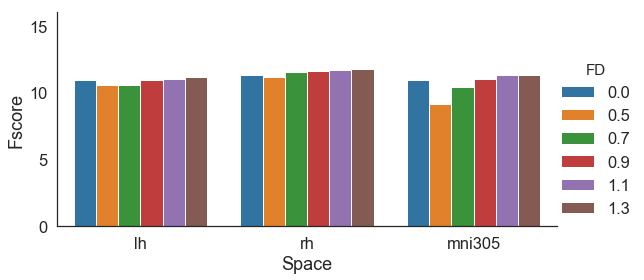

In [8]:
from my_settings import (os, op, np, read_csv, version, fs_dir,
                         root_dir, mri_dir, concat_sess_dir,
                         task,  subjects, models, plt,
                         thresholds, nib, sm, spaces,
                         n_subj, conditions_dict, DataFrame) 
import shutil
import seaborn as sns
from mne import read_surface, grow_labels, spatial_tris_connectivity, set_log_level
from mne.stats.cluster_level import _find_clusters as find_clusters
from scipy.stats import f_oneway
from scipy.stats import f as fdist
from scipy.ndimage import measurements
set_log_level(verbose=False)
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O paramters.
censor = True    # {True = Include blobs from all overlays, 
                 # False = Include blobs from only no-center}

## Cluster parameters.
cluster_dict = dict(lh = [0.01, 100], rh = [0.01, 100],
                    mni305 = [0.01, 20])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

model_name, analysis, epochs_type = models[0]
#
condition = conditions_dict[analysis][0]
#
print(model_name, analysis, epochs_type, condition)
#
info = []

for n, space in enumerate(spaces):
    #
    overlays = []
    for fd in thresholds:
    #
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Load data.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        #
        results_dir = op.join(concat_sess_dir, '%s.%s.%s.%s.%s.%s.%s.%s' % (version, task, model_name, 
                                                                            analysis, epochs_type, sm, fd, space))
        this_results_dir = op.join(results_dir, '%s.%s.%s.%s.%s.par' % (version, model_name, analysis, epochs_type, condition))
        # 
        obj = nib.load(op.join(this_results_dir, 'F.nii.gz'))
        overlays.append( obj.get_data().squeeze() )
        #
    overlays = np.array(overlays)
    #
    ## Make average map.
    if censor: average = overlays.mean(axis=0)
    else: average = overlays[0].copy()
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Identify clusters.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    p_value, min_cluster = cluster_dict[space]
    min_value = fdist.isf(p_value, 1, 26)
    #
    if space == 'mni305':
        #
        masked_average = average > min_value
        clusters, n_clusters = measurements.label( masked_average )
        clusters = [np.where(clusters==n) for n in np.arange(n_clusters)+1 if (clusters==n).sum() > min_cluster]
        #
    else:
        #
        ## Prepare surface information.
        _, tris = read_surface(os.path.join(fs_dir, 'fsaverage', 'surf', '%s.white' % space))
        connectivity = spatial_tris_connectivity(tris)
        include = np.invert(np.isnan(average).astype(bool))
        #
        ## Identify clusters (clusters already sorted by size).
        clusters, _ = find_clusters(average, min_value, tail=1, connectivity=connectivity, include=include)
        clusters = [c for c in clusters if len(c) > min_cluster]
    #
    print('%s clusters identified for %s.' %(len(clusters), space))
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Average across labels / spheres.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    #
    for i, fd in enumerate(thresholds):
        #
        for j, c in enumerate(clusters):
            #
            fscore = np.nanmean(overlays[i][c])
            info.append([fd,space,j,fscore])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
info = DataFrame(np.array(info), columns=('FD', 'Space', 'Label', 'Fscore'))
info['Fscore'] = info.Fscore.astype(float)
print(f_oneway(*[info.loc[info.FD==fd,'Fscore'].values for fd in np.unique(info.FD)]))
print(info.groupby(['FD',]).Fscore.mean())

## Plot.
g = sns.catplot('Space', 'Fscore', 'FD', info, kind='bar', ci=None, height=4, aspect=2);
g.ax.set_ylim(0,16);

Now define fd in my_settings.py, delete the existing fd.txt file in the params directory, run python my_settings.py and then fmri_first_levels/first_levels.csh with no flags